### Importações

In [1]:
import joblib
import pandas as pd
import shap
import matplotlib.pyplot as plt
import os
import numpy as np

# Configuração para os gráficos aparecerem no notebook
shap.initjs()

### Carregar Modelo e Dataset

In [2]:
output_path = "../../Models/XGBoost/"
model_path = "XGBoost_Features.pkl"

# Carregar o pipeline completo (que já inclui o preprocessor)
pipeline = joblib.load(os.path.join(output_path, model_path))

# Carregar dataset features
df = pd.read_csv('../../Data/risco_cardiovascular_features.csv')

# Separar X e y (para sabermos se ele acertou no final)
X = df.drop('BP_Category', axis=1)
y = df['BP_Category']

### Seleçionar Amostra e Inferência

In [3]:
labels_map = {
    0: "Pressão Elevada",
    "Elevated": "Pressão Elevada",
    1: "Normal",
    "Normal": "Normal",
    2: "Hipertensão Estágio 1",
    "Stage1": "Hipertensão Estágio 1"
}

# Índice Aleatório
sample_idx = np.random.randint(0, len(X))
sample_X = X.iloc[[sample_idx]]
true_label = y.iloc[sample_idx]

# Predição de Classe e Probabilidade
pred_idx = pipeline.predict(sample_X)[0]
pred_proba = pipeline.predict_proba(sample_X)[0]

print(f"Instância selecionada (índice): {sample_idx}")
print(f"--- Resultado da Inferência ---")
print(f"Classe Real: {labels_map[true_label]}")
print(f"Classe Predita: {labels_map[pred_idx]}")
print(f"Status: {'✅ Acertou' if labels_map[pred_idx] == labels_map[true_label] else '❌ Errou'}")

indices_ordenados = [1, 0, 2]
# Mostrar probabilidades para cada categoria
proba_df = pd.DataFrame({
    'Classe': [labels_map[i] for i in indices_ordenados],
    'Probabilidade Estimada': [pred_proba[i] for i in indices_ordenados]
})
print("\nProbabilidades por classe:")
print(proba_df.to_string(index=False))

Instância selecionada (índice): 71
--- Resultado da Inferência ---
Classe Real: Normal
Classe Predita: Normal
Status: ✅ Acertou

Probabilidades por classe:
               Classe  Probabilidade Estimada
               Normal                0.989170
      Pressão Elevada                0.006456
Hipertensão Estágio 1                0.004374


### Explicabilidade

In [4]:
# Dicionário de tradução para as colunas do dataset
tradução_features = {
    "Gender": "Gênero",
    "Age": "Idade",
    "Occupation": "Profissão",
    "Sleep Duration": "Duração do Sono",
    "Quality of Sleep": "Qualidade do Sono",
    "Physical Activity Level": "Nível de Atividade Física",
    "Stress Level": "Nível de Estresse",
    "BMI Category": "Categoria de IMC",
    "Heart Rate": "Freq. Cardíaca",
    "Daily Steps": "Passos Diários",
    "Sleep Disorder": "Distúrbio do Sono",
    "Sleep_Efficiency": "Eficiência do Sono",
    "Cardiac_Stress_Index": "Índice de Estresse Cardíaco"
}

--- Ficha Técnica do Paciente ---
                                     Valor
Gênero                                Male
Idade                                   33
Profissão                           Doctor
Duração do Sono                        6.1
Qualidade do Sono                        6
Nível de Atividade Física               30
Nível de Estresse                        8
Categoria de IMC             Normal Weight
Freq. Cardíaca                          72
Passos Diários                        5000
Distúrbio do Sono              No Disorder
Eficiência do Sono                    36.6
Índice de Estresse Cardíaco          576.0

Interpretando os pesos para a decisão: Normal


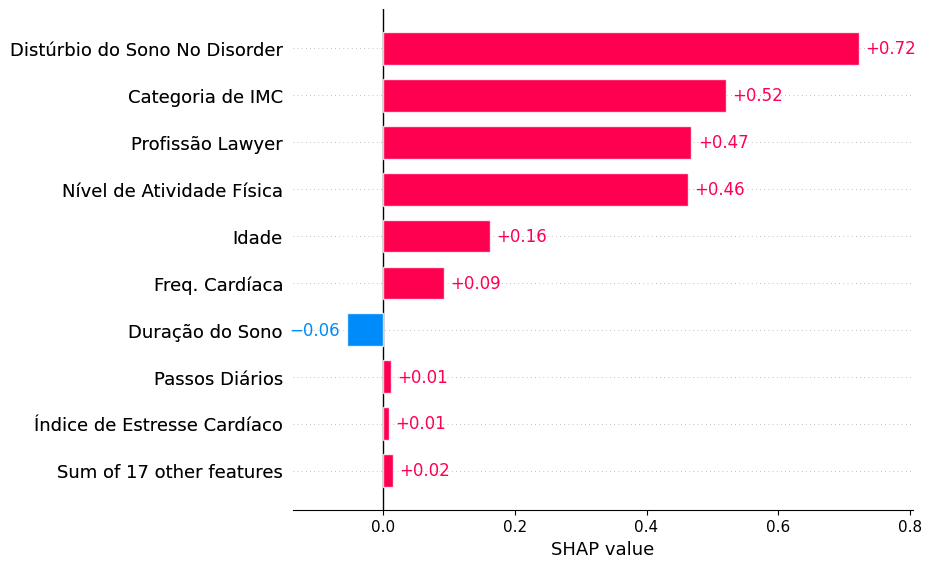

In [5]:
# Tabela de Valores Paciente
print(f"--- Ficha Técnica do Paciente ---")
perfil_paciente = sample_X.copy()
# Traduz os nomes das colunas para a tabela
perfil_paciente.columns = [tradução_features.get(c, c) for c in perfil_paciente.columns]
# Transpõe para exibição vertical
print(perfil_paciente.T.rename(columns={perfil_paciente.index[0]: 'Valor'}))

# Preparação dos dados para SHAP
preprocessor = pipeline.named_steps['preprocessor']
classifier = pipeline.named_steps['classifier']
X_transformed = preprocessor.transform(sample_X)

# Tradução simples dos nomes para o gráfico
raw_names = preprocessor.get_feature_names_out()
feature_names_pt = []

for name in raw_names:
    clean_name = name.split('__')[-1]
    translated = clean_name
    for eng, pt in tradução_features.items():
        if eng in clean_name:
            translated = clean_name.replace(eng, pt)
            break
    # Melhora visual: remove underscores e ajusta termos técnicos
    translated = translated.replace('_', ' ').replace('Gender Male', 'Gênero: Masc').replace('Gender Female', 'Gênero: Fem')
    feature_names_pt.append(translated)

# SHAP
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_transformed)

print(f"\nInterpretando os pesos para a decisão: {labels_map[pred_idx]}")

# Gráfico de Barras
shap.plots.bar(shap.Explanation(
    values=shap_values[0, :, pred_idx],
    feature_names=feature_names_pt
))

### Resultados

In [6]:
metrics_file = os.path.join(output_path, 'Metrics/XGBoost_Features_metrics.csv')

# Carregar os dados
if os.path.exists(metrics_file):
    metrics_df = pd.read_csv(metrics_file)

    # Dicionário de Tradução "técnico para clínico"
    traducao_metricas = {
        'Test_Accuracy': 'Acurácia Geral (Acerto Total)',
        'Test_Precision': 'Confiabilidade do Alerta (Precisão)',
        'Test_Recall': 'Capacidade de Detecção (Sensibilidade)',
        'Test_F1_Macro': 'Equilíbrio Clínico (F1-Score)',
        'Test_AUC_ROC': 'Poder de Discriminação (AUC)',
        'Test_Brier_Score': 'Erro de Calibração (Brier)'
    }

    # Selecionar e formatar as métricas de interesse
    resumo_tecnico = metrics_df[list(traducao_metricas.keys())].iloc[0]

    # DataFrame de exibição
    tabela_hospitalar = pd.DataFrame({
        'Indicador de Qualidade': traducao_metricas.values(),
        'Desempenho': resumo_tecnico.values
    })

    # Formatação: Porcentagem para quase tudo, exceto Brier Score
    def formatar_valor(row):
        if 'Brier' in row['Indicador de Qualidade']:
            return f"{row['Desempenho']:.4f} (Ideal: próximo a 0)"
        return f"{row['Desempenho']:.2%}"

    tabela_hospitalar['Resultado'] = tabela_hospitalar.apply(formatar_valor, axis=1)

    print("--- Relatório de Qualidade do Modelo (Contexto Hospitalar) ---")
    print(f"Modelo Analisado: {metrics_df['Model'].iloc[0]}")
    print("-" * 60)
    print(tabela_hospitalar[['Indicador de Qualidade', 'Resultado']].to_string(index=False))

    print("\n--- O que esses números significam para o médico? ---")
    print(f"• Sensibilidade: O modelo consegue identificar {resumo_tecnico['Test_Recall']:.2%} dos pacientes de risco.")
    print(f"• Precisão: Quando o alerta soa, a chance de o risco ser real é de {resumo_tecnico['Test_Precision']:.2%}.")
    print(f"• Calibração: O modelo é estatisticamente seguro para apoio à decisão clínica.")
else:
    print(f"Arquivo de métricas não encontrado em: {metrics_file}")

--- Relatório de Qualidade do Modelo (Contexto Hospitalar) ---
Modelo Analisado: XGBoost
------------------------------------------------------------
                Indicador de Qualidade                   Resultado
         Acurácia Geral (Acerto Total)                      98.67%
   Confiabilidade do Alerta (Precisão)                      98.41%
Capacidade de Detecção (Sensibilidade)                      98.99%
         Equilíbrio Clínico (F1-Score)                      98.67%
          Poder de Discriminação (AUC)                     100.00%
            Erro de Calibração (Brier) 0.0062 (Ideal: próximo a 0)

--- O que esses números significam para o médico? ---
• Sensibilidade: O modelo consegue identificar 98.99% dos pacientes de risco.
• Precisão: Quando o alerta soa, a chance de o risco ser real é de 98.41%.
• Calibração: O modelo é estatisticamente seguro para apoio à decisão clínica.
